<div align="center">
    <div> <img src="https://howsam.org/wp-content/uploads/2023/08/deep-catalyst-800-400x229.gif" alt="Drawing" style="width: 400px;"/></div>
</div>

# Facial Age Estimation

Facial age estimation is about teaching a computer program to guess how old someone is based on their face. This is a really interesting task in the world of computers and real life. However, it's not easy because there are many things that make it tricky. For example, people come in different genders and races, and they have different genes and do different exercises, which can make them look older or younger. Also, some people wear glasses, beards, mustaches, or makeup, and this can confuse the computer program when it tries to guess their age.

**Project Proposal:**

- _We require an accurate model for age prediction._
- _The model should focus on being fast, although it doesn't need to work in real-time for this project._
- _A user-friendly GUI is essential. This GUI could be in the form of a desktop app, web app, or another appropriate platform._
- _The project must include excellent and comprehensive documentation, along with comments in the source code for better understanding._



# 🔴 **Environment Setup**

## 🟠 The command for connecting Colab to the local host (PC or laptop) is as follows:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.1 MB/s eta 0:00:00


## 🟠 Change the font size of the output cells

In [23]:
print('Hello World!')

Hello World!


In [24]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 15px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [25]:
print('Hello World!')

Hello World!


# 🔴 **Import Libs**

In [ ]:
!pip install torchmetrics
!pip install facenet-pytorch

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

from facenet_pytorch import MTCNN

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
!python --version

Python 3.10.12


In [31]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
cv2 --> 4.8.0
PIL --> 9.4.0
sklearn --> 1.2.2
torch --> 2.0.1+cu118
torchvision --> 0.15.2+cu118
tqdm --> 4.66.1
torchmetrics --> 1.1.2


# 🔴 **Utils**

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Copy & Unzip the Dataset**

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!tar -xzf '/content/drive/MyDrive/UTKFace.tar.gz' -C '/content/'

* x: This flag stands for "extract". It tells the tar command to extract the files from the archive.

* v: This flag stands for "verbose". It displays the list of files being extracted in the terminal.

* z: This flag indicates that the archive file is compressed using gzip.

* f: This flag indicates that the following argument is the name of the archive file.

## 🟠 EDA

### 🟡 Let's explore the images in the UTK dataset together!

After exploring the dataset, I have identified the following:

* Estimating the age of children under 5 and adults over 100 is challenging, even for humans.
* Estimating the gender of children under 5 and adults over 100 is very difficult.
* There are some mislabeled images that could impede the learning process.

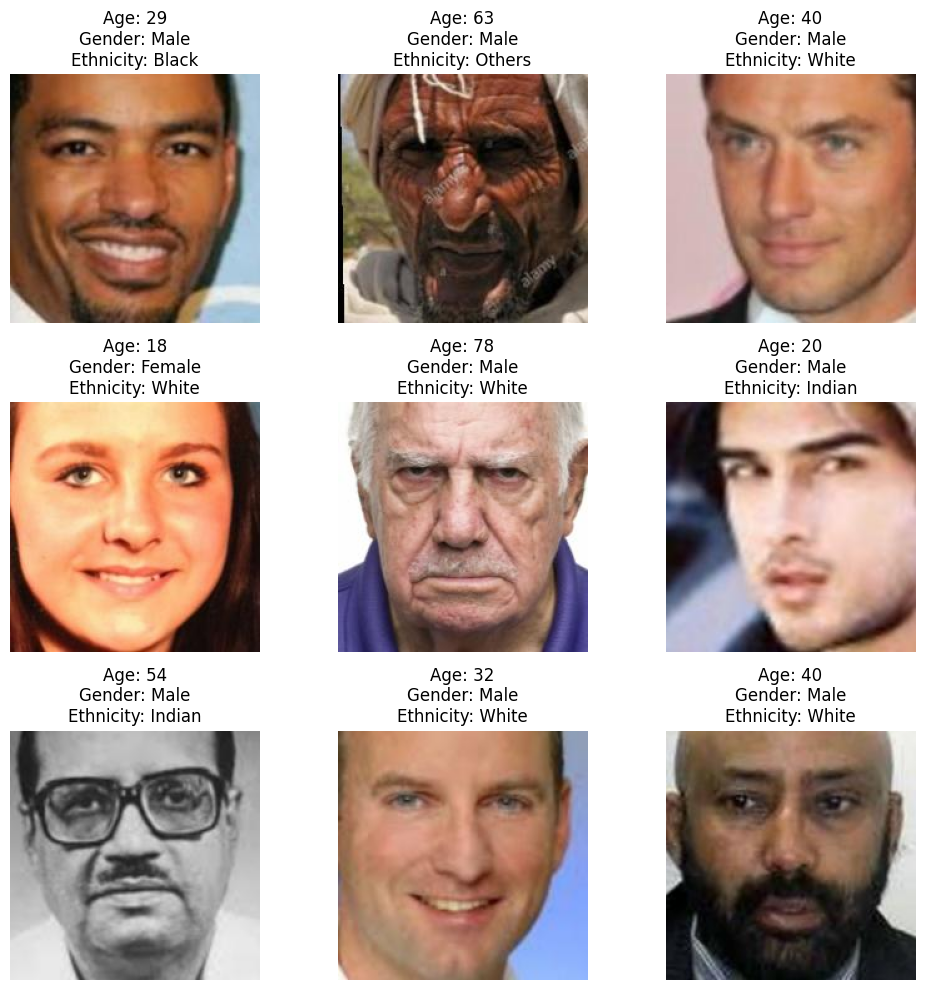

In [34]:

dataset_folder = '/content/UTKFace/'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


### 🟡 Create a csv file which contains labels

🔰 During this session, your mission is to:
   

*   create the following DataFrame
*   and save it as a CSV file named 'utkface_dataset.csv'


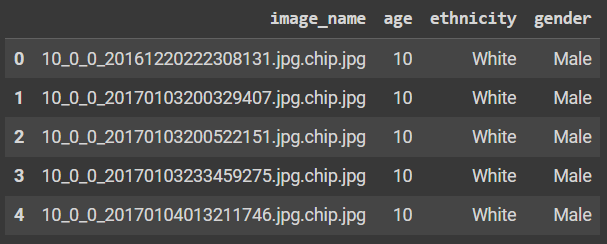

Use this code to use MTCNN face detection

In [36]:
# dataset_directory = '/content/UTKFace'

# from facenet_pytorch import MTCNN
# mtcnn = MTCNN(device=device)

# # Iterate through the files in the dataset directory
# for filename in os.listdir(dataset_directory):
#     img = Image.open(os.path.join(dataset_directory, filename))
#     _ = mtcnn(img, save_path=f'UTKFace_crop/{filename}')


In [37]:
# Replace these with the /content/UTKFace_crop if you want to use MTCNN crop
dataset_directory = '/content/UTKFace'
csv_file_path = '/content/utkface_dataset.csv'

# Create empty lists to store data
image_name = []
ages = []
genders = []
races = []

Genders = {'0':"Male", '1':"Female"}
Races = {'0':"White", '1':'Black', '2':'Asian', '3':'Indian', '4':'Others'}

# Iterate through the files in the dataset directory
for filename in os.listdir(dataset_directory):
    # Split the filename to extract attributes
    parts = filename.split('_')
    if len(parts) == 4:
        age, gender, race, _ = parts
        image_name.append(filename)
        ages.append(age)
        genders.append(Genders[gender])
        races.append(Races[race])

# Create a dictionary with the data
data = {
    'image_name': image_name,
    'Age': ages,
    'Gender': genders,
    'Race': races
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [38]:
df = pd.read_csv("/content/utkface_dataset.csv")
df

,image_name,Age,Gender,Race
0,72_0_0_20170112205248988.jpg.chip.jpg,72,Male,White
1,23_1_0_20170103163123528.jpg.chip.jpg,23,Female,White
2,35_0_1_20170117191454763.jpg.chip.jpg,35,Male,Black
3,23_1_0_20170117145105755.jpg.chip.jpg,23,Female,White
4,32_1_4_20170103225837104.jpg.chip.jpg,32,Female,Others
...,...,...,...,...
23700,1_0_3_20161219230224536.jpg.chip.jpg,1,Male,Indian
23701,75_1_0_20170120222715178.jpg.chip.jpg,75,Female,White
23702,28_1_0_20170113001234883.jpg.chip.jpg,28,Female,White
23703,1_0_0_20170110213006580.jpg.chip.jpg,1,Male,White


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Age'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Age'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Gender'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Race'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Gender', 'Race'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Age', 'Gender'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Age', 'Race'], **{'inner': 'box'})
chart

### 🟡 Plot histogram for age

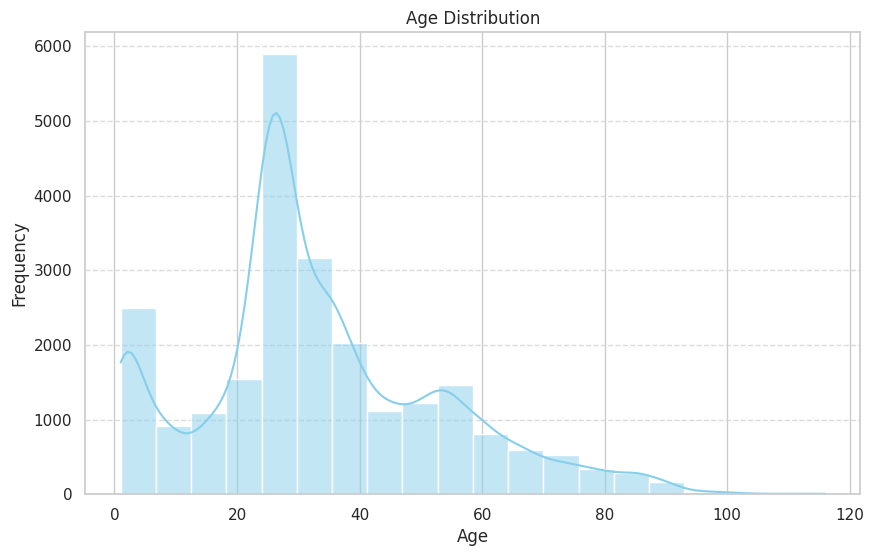

In [40]:
# Extract the 'Age' column
ages = df['Age']

# Set a seaborn style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(ages, bins=20, kde=True, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the histogram
plt.show()

#### 🛑 **Tip:** You can use Plotly or Seaborn libraries to create visually appealing plots!

### 🟡 Plot histogram for gender

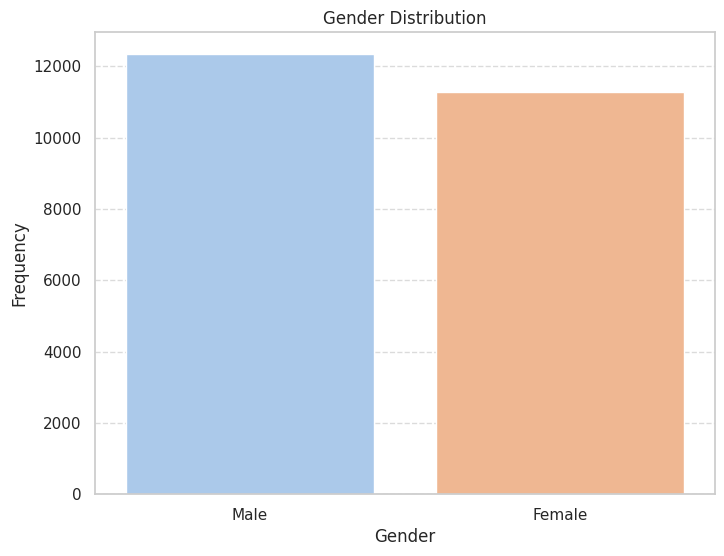

In [ ]:
# Extract the 'Gender' column
genders = df['Gender']

# Set a seaborn style
sns.set(style="whitegrid")

# Create a countplot (histogram) for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df, palette='pastel')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the histogram
plt.show()

### 🟡 Plot histogram for race

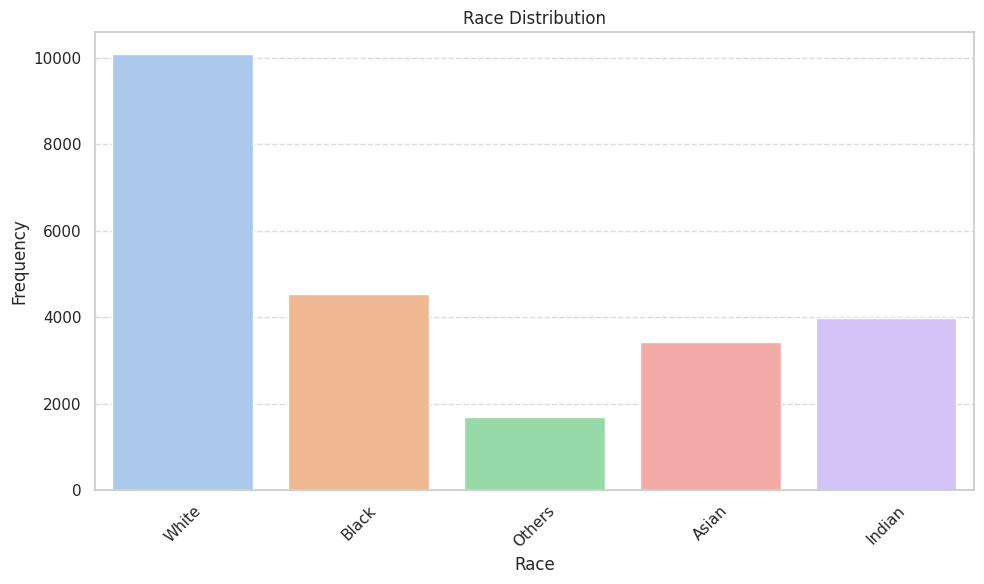

In [41]:
# Extract the 'Race' column
races = df['Race']

# Set a seaborn style
sns.set(style="whitegrid")

# Create a countplot (histogram) for race
plt.figure(figsize=(10, 6))
sns.countplot(x='Race', data=df, palette='pastel')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the histogram
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

### 🟡 Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [42]:
# Calculate the cross-tabulation of gender and ethnicity
cross_tab = pd.crosstab(df['Gender'], df['Race'])

# Display the cross-tabulation
print(cross_tab)

Race    Asian  Black  Indian  Others  White
Gender                                     
Female   1859   2208    1714     932   4601
Male     1575   2318    2261     760   5477


### 🟡 Create violin plots and box plots for age, separately for men and women.

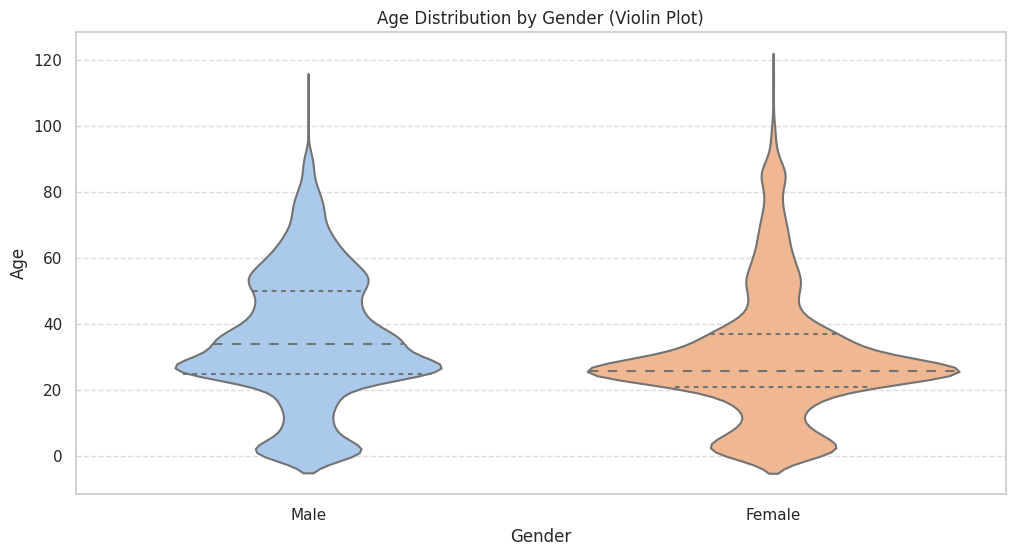

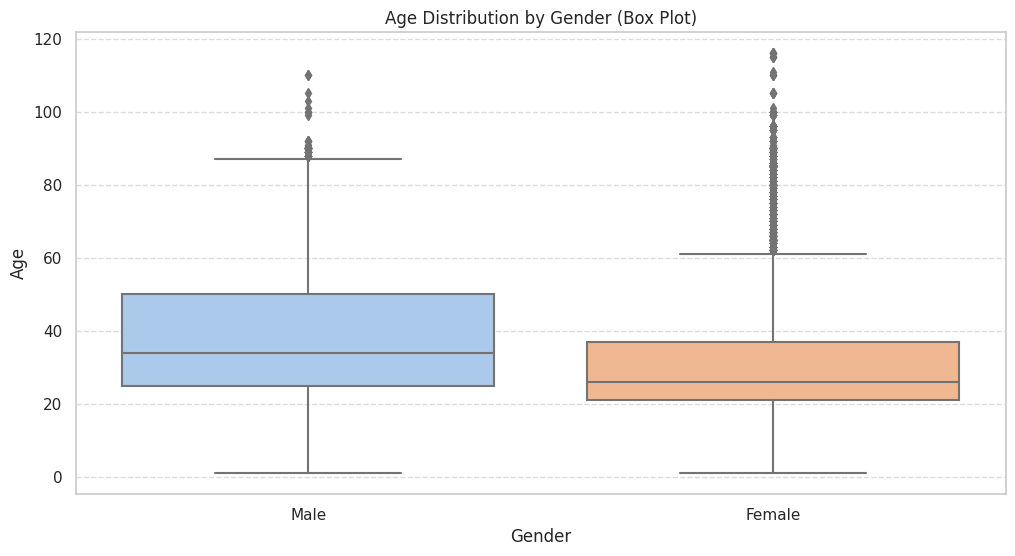

In [43]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a violin plot for age, separated by gender
plt.figure(figsize=(12, 6))
sns.violinplot(x='Gender', y='Age', data=df, palette='pastel', inner='quartile')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age Distribution by Gender (Violin Plot)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the violin plot
plt.show()

# Create a box plot for age, separated by gender
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gender', y='Age', data=df, palette='pastel')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age Distribution by Gender (Box Plot)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the box plot
plt.show()

### 🟡 Create violin plots and box plots for age, separately for each ethnicity.

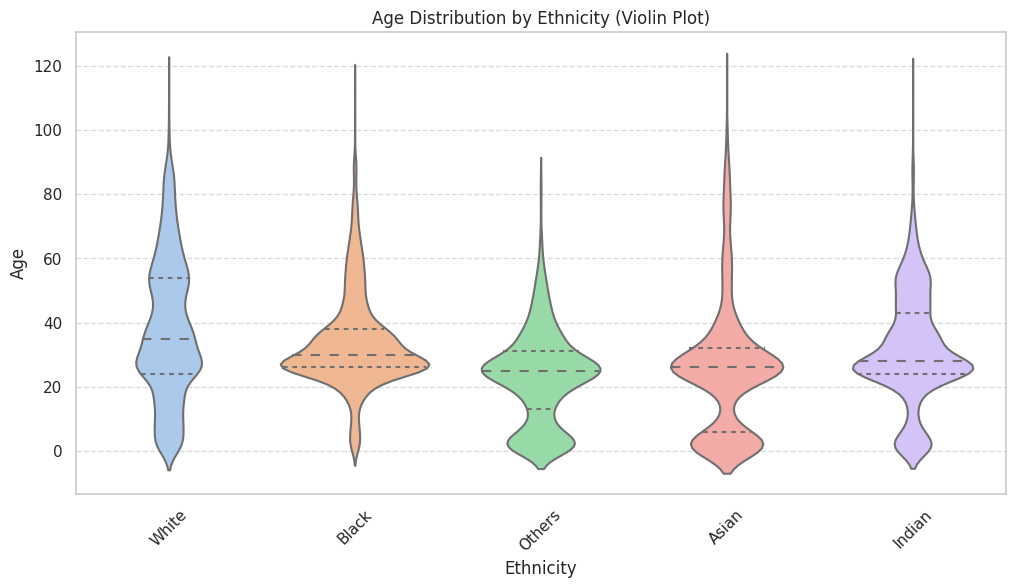

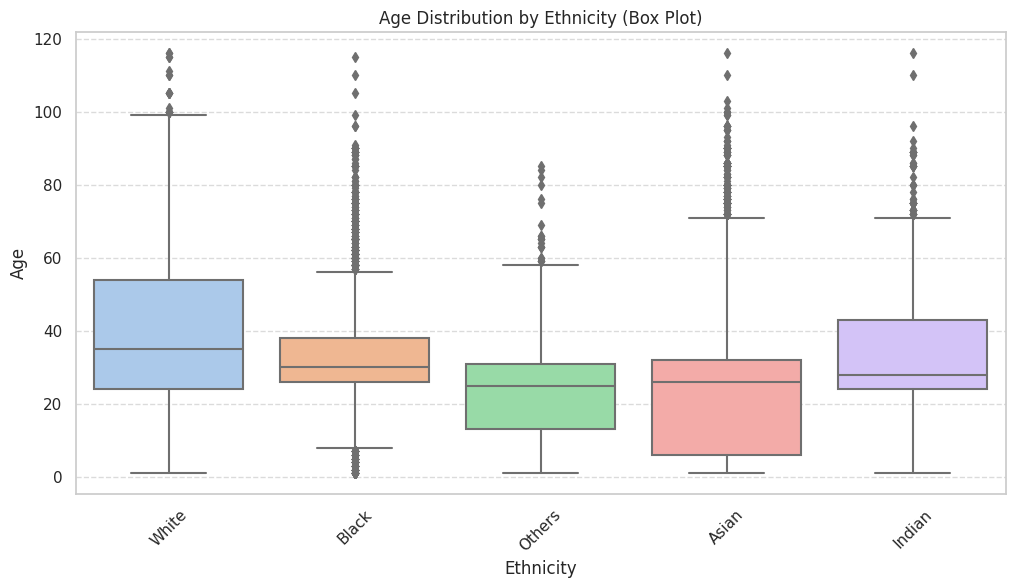

In [44]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a violin plot for age, separated by ethnicity
plt.figure(figsize=(12, 6))
sns.violinplot(x='Race', y='Age', data=df, palette='pastel', inner='quartile')
plt.xlabel('Ethnicity')
plt.ylabel('Age')
plt.title('Age Distribution by Ethnicity (Violin Plot)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the violin plot
plt.show()

# Create a box plot for age, separated by ethnicity
plt.figure(figsize=(12, 6))
sns.boxplot(x='Race', y='Age', data=df, palette='pastel')
plt.xlabel('Ethnicity')
plt.ylabel('Age')
plt.title('Age Distribution by Ethnicity (Box Plot)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the box plot
plt.show()

## 🟠 Split datasets

🔰 During this session, we use scikit-learn's train_test_split function to partition the dataset into training, validation, and test sets.

In [45]:
from sklearn.model_selection import train_test_split

# Load your annotations.csv into a DataFrame
csv_file_path = '/content/utkface_dataset.csv'
df = pd.read_csv(csv_file_path)

# Define the size of your train, validation, and test sets (e.g., 70% train, 15% validation, 15% test)
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Split the data into training set and a temporary test set
df_train, temp_test = train_test_split(df, test_size=(1 - train_size), random_state=42)

# Split the remaining data into validation and test sets
relative_test_size = test_size / (test_size + val_size)
df_val, df_test = train_test_split(temp_test, test_size=relative_test_size, random_state=42)

# Print the sizes of each set
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 16593
Validation set size: 3556
Test set size: 3556


###🟡 Plot histograms for age in the training, validation, and test sets.

⛔️ **Warning:** Ensure that the distributions of the training, validation, and test sets are similar.

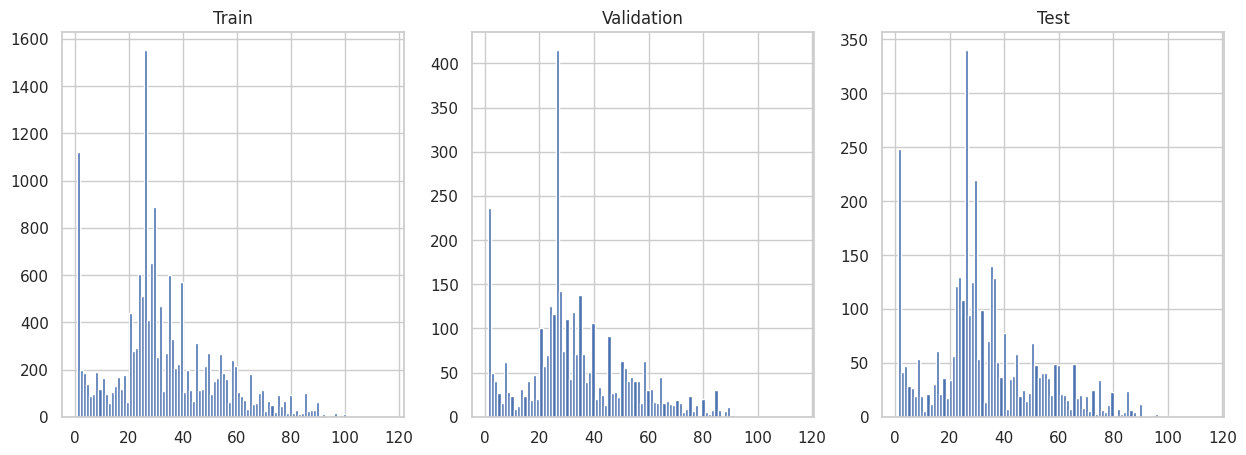

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.Age, bins=len(df_train.Age.unique())); axes[0].set_title('Train')
axes[1].hist(df_val.Age, bins=len(df_val.Age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.Age, bins=len(df_test.Age.unique())); axes[2].set_title('Test');

### 🟡 Save the training, validation, and test sets in separate CSV files.

In [47]:
df_train.to_csv('/content/train.csv', index=False)
df_val.to_csv('/content/validation.csv', index=False)
df_test.to_csv('/content/test.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## 🟠 Define transformations

🔰 During this session, our mission is to implement a data transformation pipeline using PyTorch's transforms.
The transformations should include:

*   Resizing images to a resolution of 128x128 pixels.
*   Applying random horizontal flips to the images.
*   Introducing random rotations of 15 degrees.
*   Adjusting image color using the ColorJitter transformation.
*   Converting the images to tensors.
*   Normalizing the pixel values using the provided mean and standard deviation values `(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.

In [48]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 🟠 Custom dataset

🔰 Write a custom dataset class for UTKFace.

In [49]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.df = pd.read_csv(self.csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.image_name[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        age = self.df.Age[idx]
        gender = self.df.Gender[idx]
        race = self.df.Race[idx]
        return image, age#, gender, race

🔰 Utilize the UTKDataset class you've created to instantiate dataset objects for the training, validation, and test sets.

In [52]:
train_set = UTKDataset("/content/UTKFace", "/content/train.csv", train_transform)
val_set = UTKDataset("/content/UTKFace", "/content/validation.csv", test_transform)
test_set = UTKDataset("/content/UTKFace", "/content/test.csv", test_transform)

🔰 Plot a few images to verify the functionality of the dataset objects.

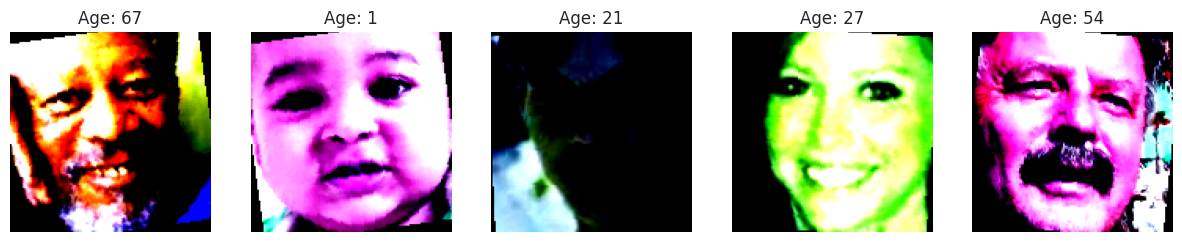

In [53]:
num_images_to_plot = 5

# Create an iterator for your dataset
data_iterator = iter(train_set)

# Create a subplot for each image
plt.figure(figsize=(15, 5))

for i in range(num_images_to_plot):
    # Get the next data item from the dataset
    data_item = next(data_iterator)
    image, label = data_item

    # Convert the tensor to a NumPy array for plotting
    image = image.permute(1, 2, 0).numpy()  # Reshape the tensor to (height, width, channels)

    # Add a subplot for each image
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.title(f'Age: {label}')

# Show the plotted images
plt.show()


## 🟠 Define dataloader

🔰 Write dataloaders for the training, validation, and test sets.

In [54]:
train_loader = torch.utils.data.DataLoader(train_set, 128, True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, 1, False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, 1, False, num_workers=2)

🔰 Test the dataloaders using `next(iter())`

In [55]:
next(iter(train_loader))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

# 🔴 **Model**

🔰 Use the following template to create a custom model employing the ResNet-50 architecture

In [56]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

🔰 Create an object for model using the AgeEstimationModel class we've created.

In [57]:
model = AgeEstimationModel()

imgs = torch.rand((64, 3, 224, 224))
model(imgs).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


torch.Size([64, 1])

# 🔴 **Config**

🔰 Define the optimizer, loss function, and metrics in this section, and ensure the model is sent to the appropriate device.

In [58]:
model = model.to(device)

In [59]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [60]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [61]:
metric = tm.MeanAbsoluteError().to(device)
metric

MeanAbsoluteError()

# 🔴 **Train ➰**

🔰Write the train function.

In [64]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None, sub_train=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for i, (inputs, targets) in enumerate(tepoch):
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device).unsqueeze(1)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

      if sub_train and i >= sub_train:
        break

  return model, loss_train.avg, metric.compute().item()

🔰test this function.

In [65]:
# train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=1)

# 🔴 **Evaluation ➰**

🔰Write the evaluation function.

In [66]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device).unsqueeze(1)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

🔰test this function.

In [67]:
# evaluate(model, val_loader, loss_fn, metric)

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = AgeEstimationModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

In [ ]:
model.eval()
loss_eval = AverageMeter()

with torch.inference_mode():
    for i, (inputs, targets) in enumerate(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)

        outputs = model(inputs)

        loss = loss_fn(outputs, targets)
        loss_eval.update(loss.item(), n=len(targets))

        if i >= 5:
            break

print(f'Mean Loss: {loss_eval.avg}')

Mean Loss: 32.83325513203939


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 19: 100%|██████████| 50/50 [00:08<00:00,  5.98batch/s, loss=10.7, metric=10.7]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
best_loss_valid = torch.inf

for lr in lrs:
    model = AgeEstimationModel().to(device)
    # model = torch.load("/content/drive/MyDrive/model.pt")
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
    print(f"Learning Rate = {lr}")
    for epoch in range(5):
        model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=epoch)
        loss_valid, acc_valid = evaluate(model, val_loader, loss_fn, metric)
        print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')

        # if loss_valid < best_loss_valid:
        #   torch.save(model, f'/content/drive/MyDrive/model.pt')
        #   best_loss_valid = loss_valid
        #   print('Model Saved!')

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
WDs = [1e-3, 1e-4, 1e-5, 1e-7]
lrs = [0.0008, 0.0005, 0.0003, 0.0001, 0.00007]

for lr in lrs:
    for wd in WDs:
        print(f"Learning Rate = {lr}")
        print(f"Weight Decay = {wd}")
        model = AgeEstimationModel().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
        # optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd)
        for epoch in range(4):
            model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=epoch)

## 🟠 Main Loop

🔰 Define model.

In [68]:
model = AgeEstimationModel().to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [69]:
lr = 0.0003
wd = 1e-04
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)

In [70]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = evaluate(model,
                                     val_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(acc_train)
  metric_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'/content/drive/MyDrive/model.pt')
    # torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 130/130 [01:13<00:00,  1.78batch/s, loss=11.2, metric=11.2]


Model Saved!
Valid: Loss = 6.674, Acc = 6.674



Epoch 1: 100%|██████████| 130/130 [01:11<00:00,  1.81batch/s, loss=6.45, metric=6.45]


Model Saved!
Valid: Loss = 5.85, Acc = 5.85



Epoch 2: 100%|██████████| 130/130 [01:12<00:00,  1.78batch/s, loss=5.76, metric=5.76]


Model Saved!
Valid: Loss = 5.665, Acc = 5.665



Epoch 3: 100%|██████████| 130/130 [01:11<00:00,  1.81batch/s, loss=5.5, metric=5.5]


Model Saved!
Valid: Loss = 5.183, Acc = 5.183



Epoch 4: 100%|██████████| 130/130 [01:11<00:00,  1.82batch/s, loss=5.26, metric=5.26]


Model Saved!
Valid: Loss = 5.182, Acc = 5.182



Epoch 5: 100%|██████████| 130/130 [01:11<00:00,  1.82batch/s, loss=5.08, metric=5.08]


Model Saved!
Valid: Loss = 5.124, Acc = 5.124



Epoch 6: 100%|██████████| 130/130 [01:11<00:00,  1.81batch/s, loss=4.86, metric=4.86]


Valid: Loss = 5.501, Acc = 5.501



Epoch 7: 100%|██████████| 130/130 [01:10<00:00,  1.83batch/s, loss=4.83, metric=4.83]


Valid: Loss = 5.144, Acc = 5.144



Epoch 8: 100%|██████████| 130/130 [01:09<00:00,  1.86batch/s, loss=4.69, metric=4.69]


Valid: Loss = 5.276, Acc = 5.276



Epoch 9: 100%|██████████| 130/130 [01:11<00:00,  1.82batch/s, loss=4.52, metric=4.52]


Valid: Loss = 5.145, Acc = 5.145



Epoch 10: 100%|██████████| 130/130 [01:09<00:00,  1.87batch/s, loss=4.47, metric=4.47]


Model Saved!
Valid: Loss = 4.958, Acc = 4.958



Epoch 11: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=4.38, metric=4.38]


Valid: Loss = 5.087, Acc = 5.087



Epoch 12: 100%|██████████| 130/130 [01:11<00:00,  1.83batch/s, loss=4.26, metric=4.26]


Valid: Loss = 5.421, Acc = 5.421



Epoch 13: 100%|██████████| 130/130 [01:10<00:00,  1.86batch/s, loss=4.2, metric=4.2]


Valid: Loss = 5.107, Acc = 5.107



Epoch 14: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=4.11, metric=4.11]


Valid: Loss = 5.158, Acc = 5.158



Epoch 15: 100%|██████████| 130/130 [01:11<00:00,  1.81batch/s, loss=4.03, metric=4.03]


Model Saved!
Valid: Loss = 4.919, Acc = 4.919



Epoch 16: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=3.92, metric=3.92]


Valid: Loss = 4.971, Acc = 4.971



Epoch 17: 100%|██████████| 130/130 [01:08<00:00,  1.89batch/s, loss=3.86, metric=3.86]


Valid: Loss = 4.941, Acc = 4.941



Epoch 18: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=3.72, metric=3.72]


Valid: Loss = 5.079, Acc = 5.079



Epoch 19: 100%|██████████| 130/130 [01:09<00:00,  1.86batch/s, loss=3.64, metric=3.64]


Model Saved!
Valid: Loss = 4.854, Acc = 4.854



In [71]:
lr = 0.00001
wd = 1e-04
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = evaluate(model,
                                     val_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(acc_train)
  metric_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'/content/drive/MyDrive/model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 130/130 [01:09<00:00,  1.86batch/s, loss=3.49, metric=3.49]


Model Saved!
Valid: Loss = 4.785, Acc = 4.785



Epoch 1: 100%|██████████| 130/130 [01:10<00:00,  1.83batch/s, loss=3.45, metric=3.45]


Model Saved!
Valid: Loss = 4.752, Acc = 4.752



Epoch 2: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=3.42, metric=3.42]


Model Saved!
Valid: Loss = 4.732, Acc = 4.732



Epoch 3: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=3.39, metric=3.39]


Model Saved!
Valid: Loss = 4.723, Acc = 4.723



Epoch 4: 100%|██████████| 130/130 [01:09<00:00,  1.88batch/s, loss=3.39, metric=3.39]


Model Saved!
Valid: Loss = 4.711, Acc = 4.711



Epoch 5: 100%|██████████| 130/130 [01:11<00:00,  1.83batch/s, loss=3.35, metric=3.35]


Model Saved!
Valid: Loss = 4.705, Acc = 4.705



Epoch 6: 100%|██████████| 130/130 [01:10<00:00,  1.84batch/s, loss=3.31, metric=3.31]


Valid: Loss = 4.71, Acc = 4.71



Epoch 7: 100%|██████████| 130/130 [01:11<00:00,  1.83batch/s, loss=3.35, metric=3.35]


Model Saved!
Valid: Loss = 4.691, Acc = 4.691



Epoch 8: 100%|██████████| 130/130 [01:11<00:00,  1.83batch/s, loss=3.31, metric=3.31]


Model Saved!
Valid: Loss = 4.686, Acc = 4.686



Epoch 9: 100%|██████████| 130/130 [01:12<00:00,  1.79batch/s, loss=3.32, metric=3.32]


Model Saved!
Valid: Loss = 4.682, Acc = 4.682



## 🟠 Plot

🔰 Plot learning curves

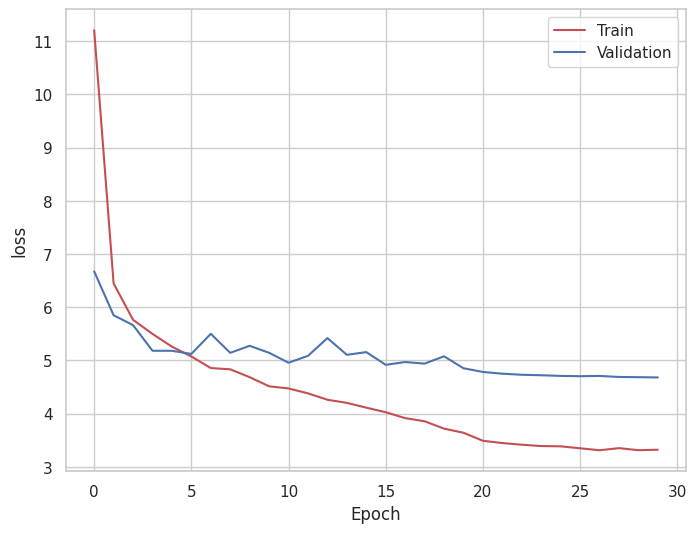

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test our model using data from the test set and images that are not present in the dataset.

In [ ]:
  net = torch.load("/content/drive/MyDrive/model.pt")
  loss_test, acc_test = evaluate(net,val_loader,loss_fn,metric)
  print(f'Valid: Loss = {loss_test:.4}, Acc = {acc_test:.4}')

Valid: Loss = 4.682, Acc = 4.682


# 🔴 **Inference**

🔰 our mission is to:

*   Write an inference function.
*   load an image from outside the UTKFace dataset
*   and evaluate the model's prediction.

In [ ]:
img = Image.open("/content/img.jpg")

In [ ]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(keep_all=True)
face_tensor, prob = mtcnn(img, save_path='faces/face.png', return_prob=True)

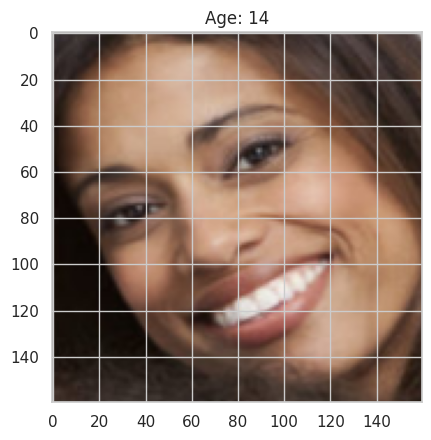

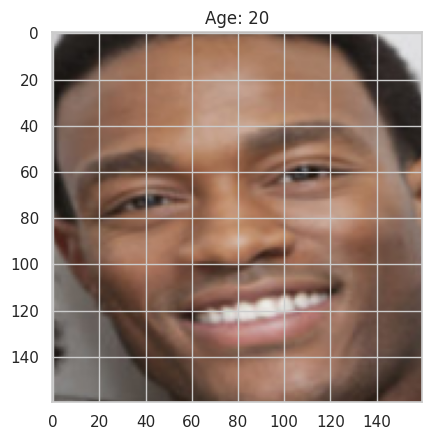

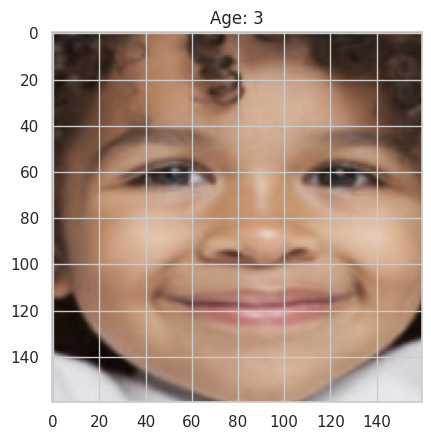

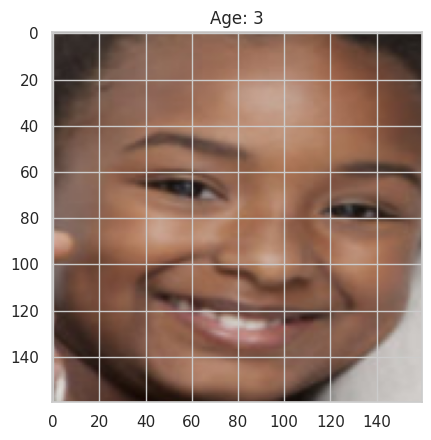

Processing completed.


In [ ]:
model = torch.load("/content/drive/MyDrive/model.pt", map_location=torch.device('cpu'))

input_folder = 'faces'
output_folder = 'output_folder'
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        # Open the image
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        # Apply your custom test_transform
        transformed_image = test_transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass through the model
        with torch.no_grad():
            output = model(transformed_image)
        # Process the output as needed (e.g., convert to probabilities or labels)

        # Draw the result on the image
        draw = PIL.ImageDraw.Draw(image)
        # You can use draw functions from PIL to annotate the image with model results

        # Display the image
        plt.imshow(image)
        plt.title(f"Age: {round(output.item())}")
        plt.show()

        # Save the modified image to the output folder
        output_path = os.path.join(output_folder, filename)
        image.save(output_path)

print("Processing completed.")

# 🔴 **Experiments**

## 🟠 Train and evaluate the model using various datasets.

We want to train and test our model with CACD2000 dataset

In [ ]:
!tar -xzf '/content/drive/MyDrive/CACD2000.tar.gz' -C '/content/'

In [ ]:
random.seed(42)

dataset_directory = '/content/CACD2000'
csv_file_path = '/content/CACD_dataset.csv'

image_name = []
ages = []

mtcnn = MTCNN()

all_files = os.listdir(dataset_directory)

selected_files = random.sample(all_files, 7000)

print("Randomly selected 7000 files:")
for filename in selected_files:
    parts = filename.split('_')
    if len(parts) == 4:
        img = Image.open(os.path.join(dataset_directory, filename))
        _ = mtcnn(img, save_path=f'CACD_new/{filename}')
        if os.path.isfile(f'CACD_new/{filename}'):
            age = parts[0]
            image_name.append(filename)
            ages.append(int(age))

data = {
    'image_name': image_name,
    'Age': ages,
}

df = pd.DataFrame(data)

df.to_csv(csv_file_path, index=False)


Randomly selected 7000 files:


In [ ]:
from sklearn.model_selection import train_test_split

csv_file_path = '/content/CACD_dataset.csv'
df = pd.read_csv(csv_file_path)

train_size = 0.8
test_size = 0.20

df_train, df_test = train_test_split(df, test_size=(1 - train_size), random_state=42)

print(f"Train set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

In [ ]:
df_train.to_csv('/content/CACD_train_dataset.csv', index=False)
df_test.to_csv('/content/CACD_test_dataset.csv', index=False)

In [ ]:
class CADDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.df = pd.read_csv(self.csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.image_name[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        age = self.df.Age[idx]
        return image, age

In [ ]:
CACD_train_set = CADDataset("/content/CACD_new", "/content/CACD_train_dataset.csv", train_transform)
CACD_test_set = CADDataset("/content/CACD_new", "/content/CACD_test_dataset.csv", test_transform)

In [ ]:
cacd_train_loader = torch.utils.data.DataLoader(CACD_train_set, 128, False, num_workers=2)
cacd_test_loader = torch.utils.data.DataLoader(CACD_test_set, 1, False, num_workers=2)

In [ ]:
model = torch.load("/content/drive/MyDrive/model.pt").to(device)

In [ ]:
lr = 0.00001
wd = 1e-04
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)

In [ ]:
best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = evaluate(model,
                                     val_loader,
                                     loss_fn,
                                     metric)


  if loss_valid < best_loss_valid:
    torch.save(model, f'/content/drive/MyDrive/model_CACD.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Train the model using one dataset and then test it on a different one.

test our trained model on CACD2000 dataset without traing

In [ ]:
!tar -xzf '/content/drive/MyDrive/CACD2000.tar.gz' -C '/content/'

In [ ]:
# Replace these with the actual paths to your dataset and where you want to save the CSV file
dataset_directory = '/content/CACD2000'
csv_file_path = '/content/CACD_dataset.csv'

# Create empty lists to store data
image_name = []
ages = []

from facenet_pytorch import MTCNN
mtcnn = MTCNN()

# Iterate through the files in the dataset directory
for i, filename in enumerate(os.listdir(dataset_directory)):

    parts = filename.split('_')
    if len(parts) == 4:
        img = Image.open(os.path.join(dataset_directory, filename))
        _ = mtcnn(img, save_path=f'CACD1000/{filename}')
        if os.path.isfile(f'CACD1000/{filename}'):
            age, _, _, _ = parts
            image_name.append(filename)
            ages.append(int(age))

    if i >= 2000:
        break

# Create a dictionary with the data
data = {
    'image_name': image_name,
    'Age': ages,
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [ ]:
class CADDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.df = pd.read_csv(self.csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.image_name[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        age = self.df.Age[idx]
        return image, age

In [ ]:
ds = CADDataset("/content/CACD1000", "/content/CACD_dataset.csv", test_transform)
len(ds)

1871

In [ ]:
cad_loader = torch.utils.data.DataLoader(ds, 1, False, num_workers=2)

In [ ]:
model = torch.load("/content/drive/MyDrive/model.pt")

loss, _ = evaluate(model, cad_loader, loss_fn, metric)

print(f"CACD2000 Loss = {loss}")

CACD2000 Loss = 10.890089192025997


## 🟠 Analyze the MAE value with respect to age, gender and race.

In [ ]:
all_outputs, all_targets = [], []

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    outputs = model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

In [ ]:
all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()
all_outputs.shape, all_targets.shape

(torch.Size([3475]), torch.Size([3475]))

In [ ]:
mae = F.l1_loss(all_outputs, all_targets, reduction='none')
mae.shape

torch.Size([3475])

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')

df_test['preds'] = all_outputs.cpu()
df_test['maes'] = mae.cpu()
df_test.to_csv('/content/test_outputs.csv')
df_test.head()

,image_name,age,ethnicity,gender,preds,maes
0,56_0_0_20170111211219557.jpg.chip.jpg,56,White,Male,62.469162,6.469162
1,48_1_1_20170113001756978.jpg.chip.jpg,48,Black,Female,45.094574,2.905426
2,34_0_3_20170119163319768.jpg.chip.jpg,34,Indian,Male,26.050079,7.949921
3,46_0_0_20170117172149820.jpg.chip.jpg,46,White,Male,51.015930,5.015930
4,4_1_0_20170109192831145.jpg.chip.jpg,4,White,Female,4.803345,0.803345


In [ ]:
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,168.0,0.389224,1.923051,0.001850,0.052314,0.125476,0.257917,24.665125
2,72.0,0.914027,2.915755,0.043929,0.302487,0.607371,0.844322,25.176619
3,43.0,1.272669,1.094575,0.039776,0.603820,1.244751,1.497289,5.921664
4,41.0,1.289426,0.883808,0.096410,0.762811,1.032654,1.652438,3.619977
5,29.0,4.087986,11.722061,0.003478,0.652091,1.531191,2.427211,63.846085
...,...,...,...,...,...,...,...,...
76,8.0,8.892060,7.021187,1.053177,3.113369,9.274540,11.383196,22.718590
77,4.0,17.300947,21.480959,1.489090,6.167801,9.370941,20.504087,48.972816
78,10.0,5.740116,3.690342,0.846886,2.524683,6.559471,8.118177,10.914688


<BarContainer object of 80 artists>

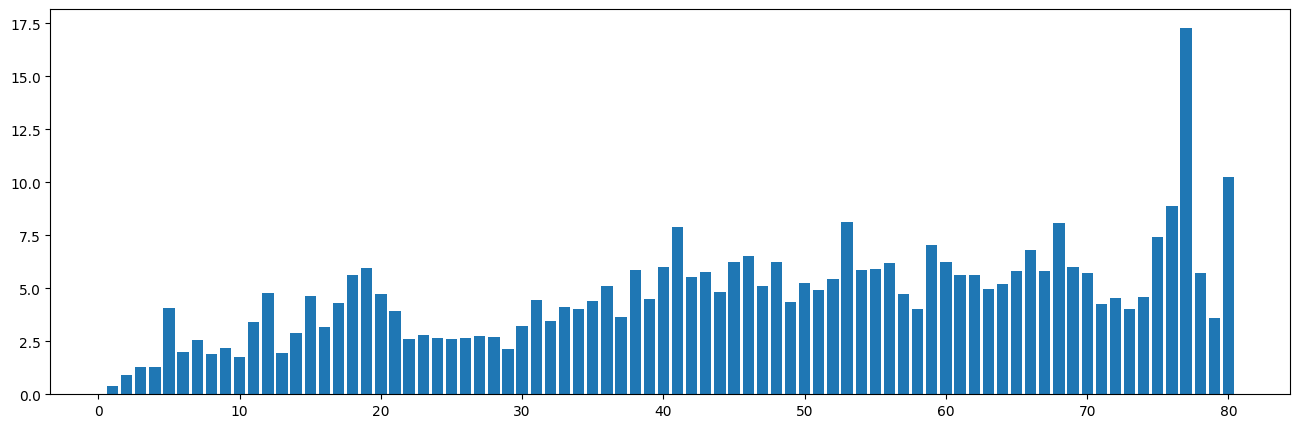

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])

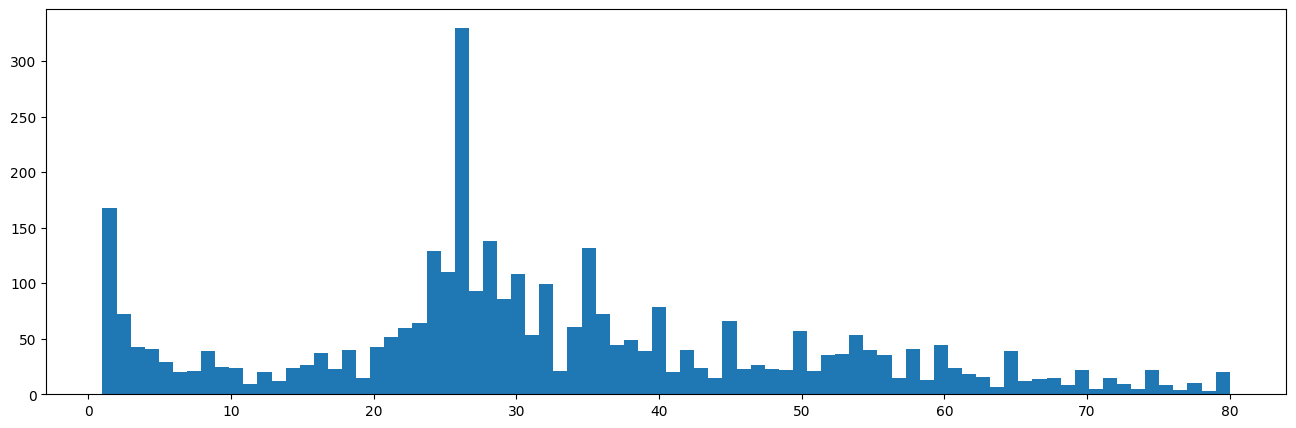

In [ ]:
plt.figure(figsize=(16, 5))
plt.hist(df_test.age, bins=len(df_test.age.unique()));

In [ ]:
df_test.groupby('gender')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1642.0,3.638013,4.071262,0.003473,0.877436,2.247769,5.146206,35.854446
Male,1833.0,4.055799,4.588873,0.001850,1.011410,2.653451,5.567177,63.846085


In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,481.0,2.678043,3.435051,0.003478,0.451847,1.517508,3.579519,28.960670
Black,682.0,4.165312,4.912383,0.009321,1.186602,2.728031,5.519853,63.846085
Indian,599.0,3.802157,4.099485,0.003111,0.925159,2.293163,5.360360,28.494675
Others,264.0,3.005197,3.734072,0.001850,0.651750,1.533026,4.287949,25.814035
White,1449.0,4.284438,4.469285,0.008339,1.174294,2.798244,6.025372,36.115005


In [ ]:
ranges = np.arange(df.age.min()-1, df.age.max()+1, 5)
df_test['age_period'] = pd.cut(df.age, bins=ranges)
df_test.head()

,image_name,age,ethnicity,gender,preds,maes,age_period
0,56_0_0_20170111211219557.jpg.chip.jpg,56,White,Male,62.469162,6.469162,"(55, 60]"
1,48_1_1_20170113001756978.jpg.chip.jpg,48,Black,Female,45.094574,2.905426,"(45, 50]"
2,34_0_3_20170119163319768.jpg.chip.jpg,34,Indian,Male,26.050079,7.949921,"(30, 35]"
3,46_0_0_20170117172149820.jpg.chip.jpg,46,White,Male,51.015930,5.015930,"(45, 50]"
4,4_1_0_20170109192831145.jpg.chip.jpg,4,White,Female,4.803345,0.803345,"(0, 5]"


<BarContainer object of 16 artists>

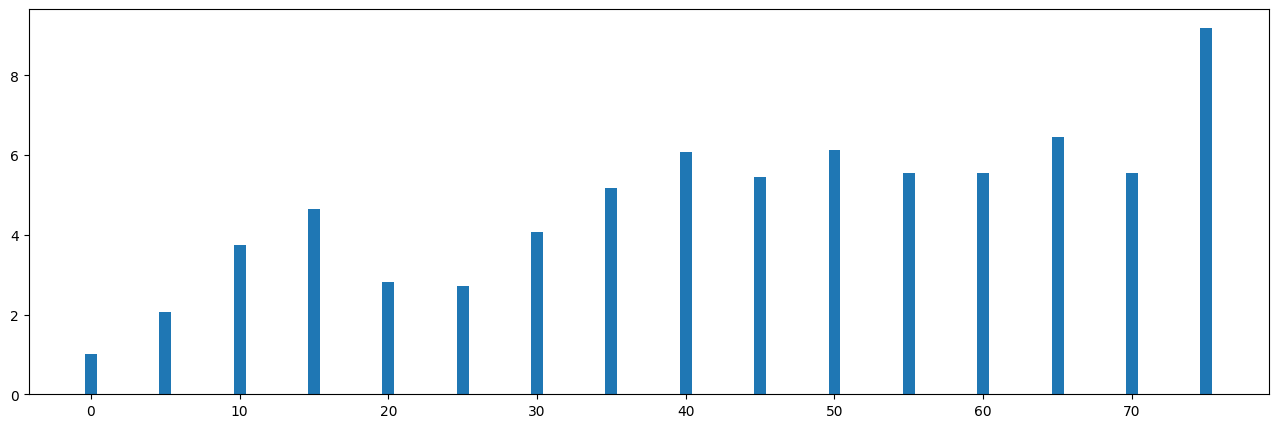

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(ranges[:-1],
        df_test.groupby('age_period')['maes'].describe()['mean']);

In [ ]:
df_test.groupby('age_period')['maes'].describe().index

CategoricalIndex([  (0, 5],  (5, 10], (10, 15], (15, 20], (20, 25], (25, 30],
                  (30, 35], (35, 40], (40, 45], (45, 50], (50, 55], (55, 60],
                  (60, 65], (65, 70], (70, 75], (75, 80]],
                 categories=[(0, 5], (5, 10], (10, 15], (15, 20], ..., (60, 65], (65, 70], (70, 75], (75, 80]], ordered=True, dtype='category', name='age_period')

In [ ]:
df_test.groupby('age_period')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age_period,,,,,,,,
"(0, 5]",353.0,1.012302,3.951579,0.001850,0.108633,0.324937,0.939247,63.846085
"(5, 10]",129.0,2.065547,2.221923,0.008767,0.591191,1.485270,2.686879,15.923677
"(10, 15]",91.0,3.736832,3.847648,0.030261,1.209951,2.489079,4.582698,19.172451
"(15, 20]",158.0,4.642495,3.773522,0.146357,1.997196,4.191664,6.471102,35.451073
"(20, 25]",415.0,2.817732,2.882396,0.007601,0.852702,1.888273,3.758379,19.428413
"(25, 30]",755.0,2.704500,3.112689,0.003111,0.840248,1.791012,3.411015,36.115005
"(30, 35]",366.0,4.076678,3.162982,0.015032,1.754726,3.469629,5.769188,19.447178
"(35, 40]",283.0,5.177219,3.951563,0.008339,1.947889,4.455368,7.517690,20.117664
"(40, 45]",165.0,6.076422,4.826535,0.097233,2.590431,4.608017,9.079330,26.737850


## 🟠 Create a heatmap for the face images.

this part gonna update in future

# 🔴 **Use the model to perform age estimation on a webcam image.**

⛔️ You cannot perform this task using Jupyter Notebook or Google Colab. For this session, please use IDEs such as PyCharm or VSCode(future work).